In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


### Data Preparation

In [21]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [22]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [25]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
x_dev,x_test,y_dev,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

#train 0.7
#dev 0.15
#test 0.15

In [26]:
#norm


scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_dev=scaler_x.transform(x_dev)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_dev=scaler_y.transform(y_dev.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))


### Tests

In [27]:

epochs=2000
model_nn = MLPRegressor(hidden_layer_sizes=(64,64,64),
                        max_iter=epochs,
                        solver='adam',
                        activation='tanh',
                        random_state=42,)

#fit
model_nn.fit(x_train,y_train.ravel())

#get predictions
test_pred=model_nn.predict(x_test)
dev_pred=model_nn.predict(x_dev)
train_pred=model_nn.predict(x_train)

test_mse = mean_squared_error(y_test, test_pred)
dev_mse=mean_squared_error(y_dev,dev_pred)
train_mse=mean_squared_error(y_train,train_pred)

print('train mse: ' +str(train_mse)+'\n'+'dev mse: ' +str(dev_mse)+'\n'+'test mse: '+str(test_mse))


train mse: 0.040087279857628166
dev mse: 0.09677486236878897
test mse: 0.10104839584805807


In [28]:
(train_mse-dev_mse)/dev_mse*100

-58.5767637624078

Text(0.5, 1.0, "Before 'boruta'")

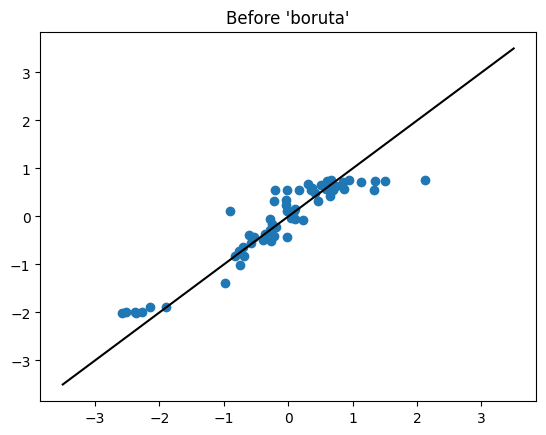

In [8]:
#parity on test set
plt.scatter(y_test, test_pred)
plt.plot([-3.5,3.5],[-3.5,3.5],'black')
plt.title('Before \'boruta\'')

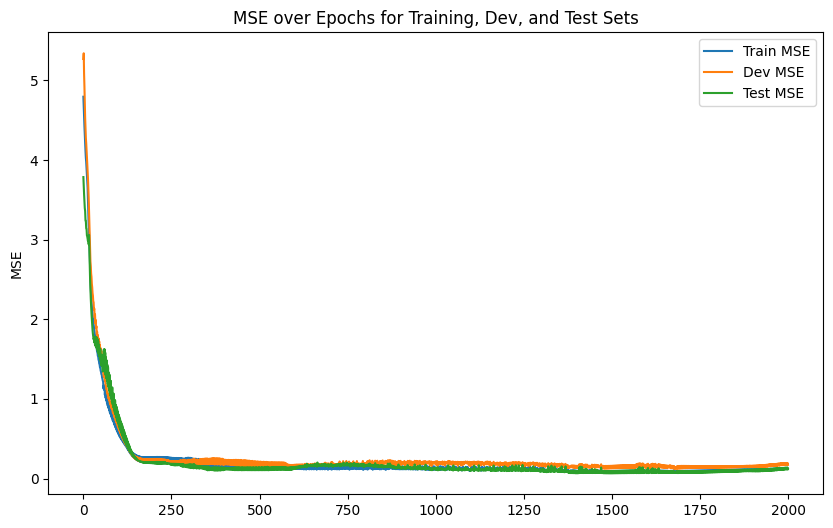

In [204]:
##learning curves
epochs=2000
model_nn = MLPRegressor(hidden_layer_sizes=(2,2),
                        max_iter=1,
                        solver='adam',
                        activation='tanh',
                        random_state=42,
                        warm_start=True)

train_mse_arr=[]
dev_mse_arr=[]
test_mse_arr=[]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",
                            category=ConvergenceWarning,
                            module="sklearn")

    for epoch_num in range(epochs):
        model_nn.fit(x_train,y_train.ravel())
        
        train_pred=model_nn.predict(x_train)
        dev_pred=model_nn.predict(x_dev)
        test_pred=model_nn.predict(x_test)
        
        train_mse=mean_squared_error(y_train,train_pred)
        dev_mse=mean_squared_error(y_dev,dev_pred)
        test_mse=mean_squared_error(y_test,test_pred)
        
        train_mse_arr.append(train_mse)
        dev_mse_arr.append(dev_mse)
        test_mse_arr.append(test_mse)


plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_mse_arr, label='Train MSE')
plt.plot(range(epochs), dev_mse_arr, label='Dev MSE')
plt.plot(range(epochs), test_mse_arr, label='Test MSE')
plt.ylabel('MSE')
plt.title('MSE over Epochs for Training, Dev, and Test Sets')
plt.legend()
plt.show()
    
    

### Importance evaluation Holdout/External validation


In [29]:
def eval_importance_holdout(architecture,fitX,fitY,importanceX,importanceY):
    importance_df=pd.DataFrame()
    
    for structure_nn in architecture:
        
        # Train MLPRegressor
        model_nn = MLPRegressor(hidden_layer_sizes=structure_nn,
                        max_iter=2000,
                        solver='adam',
                        activation='tanh',
                        random_state=42,)

        
        model_nn.fit(fitX, fitY.ravel())

        # Perform permutation importance
        results = permutation_importance(model_nn,
                                         importanceX,
                                         importanceY,
                                         n_repeats=30,
                                         random_state=42,
                                         n_jobs=4,
                                         scoring='neg_mean_squared_error')
        
        # Get the importance of the features
        importance = results.importances_mean
        
        #replace negative values by zero
        importance[importance<0]=0
        
        #norm
        scaler=MinMaxScaler()
        importance=scaler.fit_transform(importance.reshape(-1,1)).flatten()
    
        importance_df['layers'+str(structure_nn)]=importance
    return importance_df

In [39]:
layers=[(2,2,2),(2,2),(2,4,2),(4,4,2,2,2),(8,5,16,4,4),(32,32,32),(64,64,64)]
importance_holdout=eval_importance_holdout(architecture=layers,
                                           fitX=x_train,
                                           fitY=y_train,
                                           importanceX=x_train,
                                           importanceY=y_train)

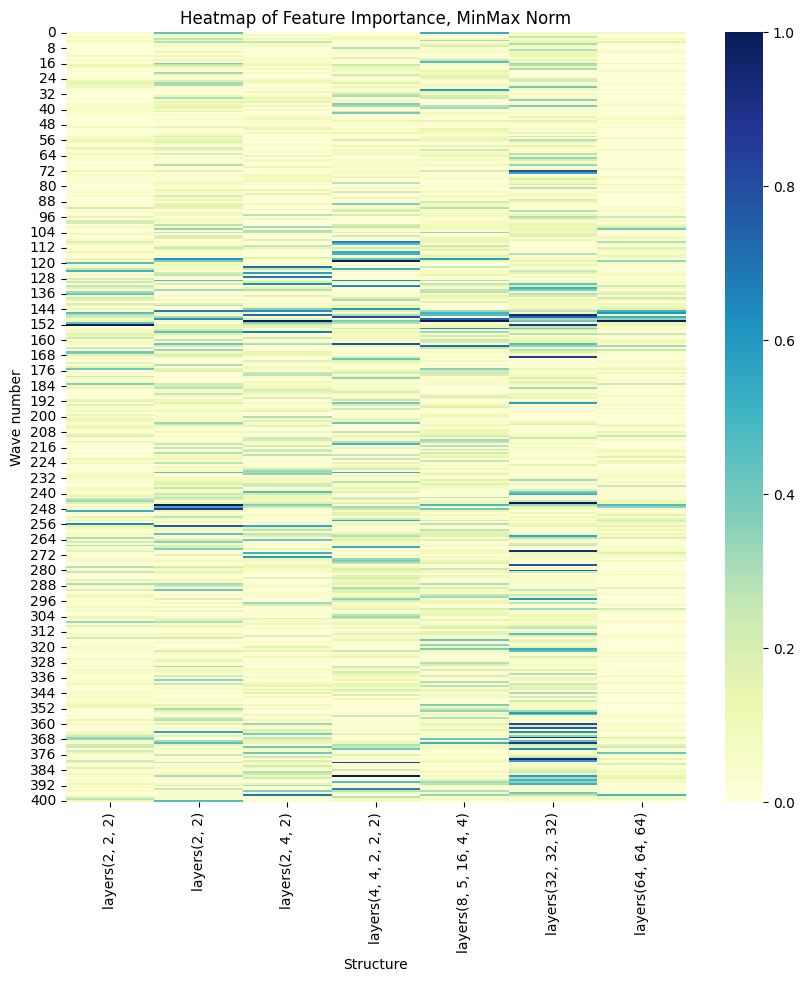

In [40]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_holdout, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance, MinMax Norm')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()


### benchmarking Holdout

In [32]:
def print_long(frame):
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,):
     print(frame)

In [55]:
#turn into function?

#dev MSE for different models with various thresholds(i)

#get some values for different training
layers=[(2,2,2),(2,2),(2,4,2),(4,4,2,2,2),(8,5,16,4,4)]

stored = pd.DataFrame()

x_train=pd.DataFrame(x_train)
x_dev=pd.DataFrame(x_dev)
x_test=pd.DataFrame(x_test)

for structure in layers:
    
    for i in np.arange(0,0.4,0.05):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_holdout.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train[columns_to_keep]
        x_dev_important=x_dev[columns_to_keep]
        
        #get predictions
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=2000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train.ravel())
        
        dev_pred_important=model_nn.predict(x_dev_important)
        dev_mse_i = mean_squared_error(y_dev, dev_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = dev_mse_i

In [56]:
stored

,"layers(2, 2, 2)","layers(2, 2)","layers(2, 4, 2)","layers(4, 4, 2, 2, 2)","layers(8, 5, 16, 4, 4)"
0.00,0.170282,0.109826,0.246253,0.205021,0.125931
0.05,0.158532,0.155307,0.185209,0.272568,0.147931
0.10,0.211731,0.173918,0.073286,0.339980,0.087683
0.15,0.226181,0.084404,0.057490,0.168353,0.146437
0.20,0.249266,0.176500,0.109389,0.130537,0.076723
0.25,0.169575,0.113088,0.146741,0.138678,0.079968
0.30,0.256515,0.131323,0.159294,0.140729,0.120539
0.35,0.232067,0.167753,0.128322,0.115480,0.179988


In [34]:
# all sets mse for different tresholds

structure=(64,64,64)
columns=['threshold','train mse','dev mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)

x_train=pd.DataFrame(x_train)
x_dev=pd.DataFrame(x_dev)
x_test=pd.DataFrame(x_test)

for i in np.arange(0,0.3,0.01):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_holdout.T.loc['layers'+str(structure),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train[columns_to_keep]
    x_dev_important=x_dev[columns_to_keep]
    x_test_important=x_test[columns_to_keep]
    
    #get predictions
    model_nn= MLPRegressor(hidden_layer_sizes=structure,
                           max_iter=2000,
                           solver='adam',
                           activation='tanh',
                           random_state=42)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    dev_pred_important=model_nn.predict(x_dev_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train,train_pred_important)
    dev_mse_i=mean_squared_error(y_dev,dev_pred_important)
    test_mse_i = mean_squared_error(y_test, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,dev_mse_i,test_mse_i,num_features]

In [35]:
stored_2

,threshold,train mse,dev mse,test mse,wavelengths included
0.00,0.00,0.040087,0.096775,0.101048,401.0
0.01,0.01,0.026501,0.078575,0.090591,279.0
0.02,0.02,0.017954,0.064584,0.090580,230.0
0.03,0.03,0.011558,0.056918,0.051444,196.0
0.04,0.04,0.029299,0.091937,0.076817,174.0
0.05,0.05,0.014391,0.063109,0.053294,145.0
0.06,0.06,0.017859,0.071524,0.064027,132.0
0.07,0.07,0.018438,0.089189,0.081142,113.0
0.08,0.08,0.018082,0.068498,0.065006,94.0
0.09,0.09,0.016290,0.068746,0.056962,81.0


### benchmarking Cross

In [36]:
#data split and normalisation
x_train_cv,x_test_cv,y_train_cv,y_test_cv=train_test_split(X,Y,test_size=0.3,random_state=42)

#train 0.7
#test 0.3

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train_cv)
x_train_cv=scaler_x.transform(x_train_cv)
x_test_cv=scaler_x.transform(x_test_cv)

scaler_y=StandardScaler()
scaler_y.fit(y_train_cv.values.reshape(-1,1))
y_train_cv=scaler_y.transform(y_train_cv.values.reshape(-1,1))
y_test_cv=scaler_y.transform(y_test_cv.values.reshape(-1,1))

In [37]:
#evaluate importance in each fold then take mean
layers=[(2,2,2),(2,2),(2,4,2),(4,4,2,2,2),(8,5,16,4,4),(32,32,32),(64,64,64)]

importance_df_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)

x_train_cv=pd.DataFrame(x_train_cv)

for structure in layers:
    
    fold_importance=np.zeros((x_train_cv.shape[1],kf.n_splits))
    
    for fold, (train_index, test_index) in enumerate(kf.split(x_train_cv)):
        
        
        x_train_fold=x_train_cv.iloc[train_index]
        x_val_fold=x_train_cv.iloc[test_index]
        y_train_fold=y_train_cv[train_index]
        y_val_fold=y_train_cv[test_index]
        
        #modelo
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=2000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)
        
        model_nn.fit(x_train_fold,y_train_fold.ravel())
        #permutation importance
        results=permutation_importance(model_nn,x_val_fold,y_val_fold,n_repeats=20,random_state=42, n_jobs=4)
        
        fold_importance[:,fold]=results.importances_mean
        
    #get average among kfolds
    mean_importance=fold_importance.mean(axis=1)
    
    #zero out neg values
    mean_importance[mean_importance<0]=0
    
    #norm
    scaler=MinMaxScaler()
    norm_importance=scaler.fit_transform(mean_importance.reshape(-1,1)).flatten()
    
    #store to frame
    importance_df_cross['layers'+str(structure)]=norm_importance
    

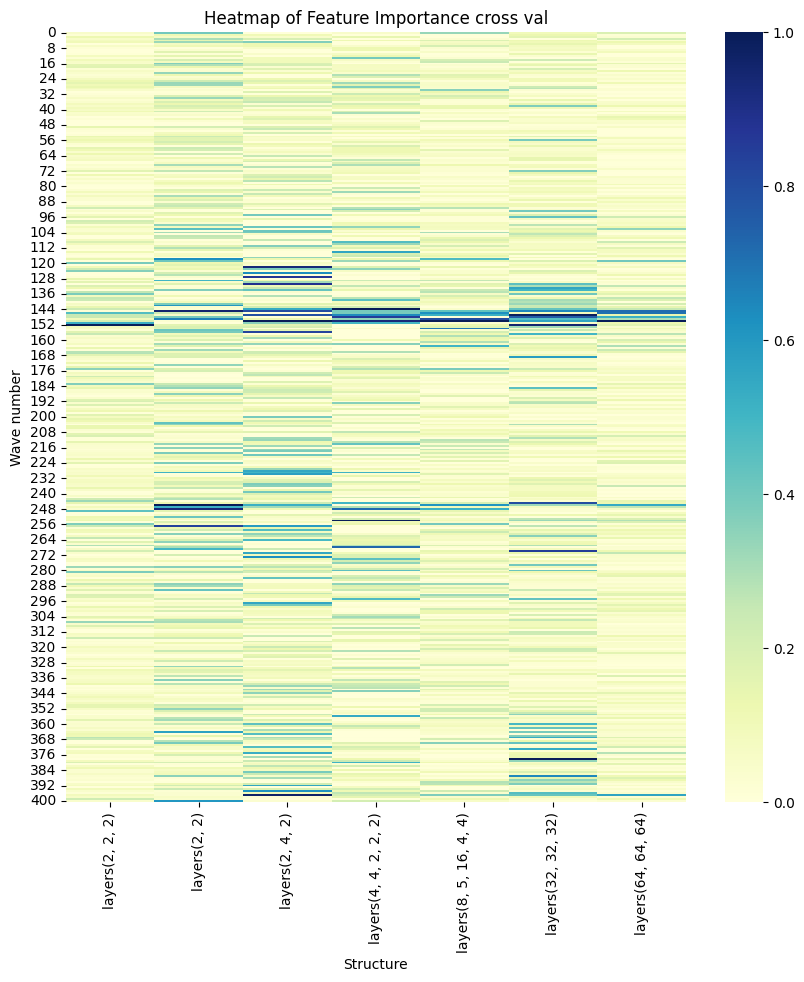

In [38]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_df_cross, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance cross val')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()

In [8]:
#turn into function?

#dev MSE for different models with various thresholds(i) CROSS

#get some values for different training
layers=[(2,2,2),(2,2),(2,4,2),(4,4,2,2,2),(8,5,16,4,4),(32,32,32)]

stored = pd.DataFrame()

x_train_cv=pd.DataFrame(x_train_cv)

for structure in layers:
    
    for i in np.arange(0,0.3,0.01):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_df_cross.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train_cv[columns_to_keep]
        
        #get predictions
        model_nn= MLPRegressor(hidden_layer_sizes=structure,
                               max_iter=2000,
                               solver='adam',
                               activation='tanh',
                               random_state=42)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train_cv.ravel())
        
        train_pred_important=model_nn.predict(x_train_important)
        train_mse_i = mean_squared_error(y_train_cv, train_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = train_mse_i

In [9]:
stored

,"layers(2, 2, 2)","layers(2, 2)","layers(2, 4, 2)","layers(4, 4, 2, 2, 2)","layers(8, 5, 16, 4, 4)","layers(32, 32, 32)"
0.00,0.149078,0.099703,0.178139,0.169471,0.077207,0.017960
0.01,0.099170,0.064966,0.076101,0.399712,0.102502,0.038806
0.02,0.207742,0.056534,0.117703,0.383470,0.056945,0.013595
0.03,0.209813,0.069272,0.099979,0.158419,0.080181,0.034861
0.04,0.144267,0.241051,0.054513,0.088708,0.049865,0.032220
0.05,0.070884,0.089282,0.192405,0.056083,0.048756,0.050267
0.06,0.268566,0.165917,0.152201,0.228925,0.036250,0.015542
0.07,0.076353,0.209946,0.062799,0.135738,0.032055,0.012954
0.08,0.076761,0.232859,0.087634,0.083927,0.035153,0.019808
0.09,0.079941,0.062146,0.174107,0.040276,0.065540,0.016357


In [54]:
# all sets mse for different tresholds

layers_structure=(64,64,64)
columns=['threshold','train mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)

x_train_cv=pd.DataFrame(x_train_cv)
x_test_cv=pd.DataFrame(x_test_cv)

for i in np.arange(0,0.3,0.01):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_df_cross.T.loc['layers'+str(layers_structure),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train_cv[columns_to_keep]
    x_test_important=x_test_cv[columns_to_keep]
    
    #get predictions
    model_nn= MLPRegressor(hidden_layer_sizes=layers_structure,
                           max_iter=2000,
                           solver='adam',
                           activation='tanh',
                           random_state=42)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train_cv.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train_cv,train_pred_important)
    test_mse_i = mean_squared_error(y_test_cv, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,test_mse_i,num_features]

In [55]:
stored_2

,threshold,train mse,test mse,wavelengths included
0.00,0.00,0.040087,0.098930,401.0
0.01,0.01,0.017362,0.071002,327.0
0.02,0.02,0.040537,0.094115,287.0
0.03,0.03,0.030107,0.085666,250.0
0.04,0.04,0.013020,0.077252,212.0
0.05,0.05,0.023369,0.072456,173.0
0.06,0.06,0.016828,0.067358,147.0
0.07,0.07,0.019878,0.075574,129.0
0.08,0.08,0.019817,0.094948,110.0
0.09,0.09,0.014971,0.083092,100.0


In [63]:
#cross to evaluate importance and cross validation with important features
#this manner sort of dilutes the results and i can't find the better model...
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)



for structure in layers:
    
    for i in np.arange(0,0.9,0.15):
        
        fold_scores=np.empty(5)
    
        for fold, (train_index,test_index) in enumerate(kf.split(X)):
            
            x_train_fold,x_val_fold=X.iloc[train_index],X.iloc[test_index]
            y_train_fold,y_val_fold=Y[train_index],Y[test_index]

            #get indexing of only features with importance over i over layer 'structure'
            importance=importance_df_cross.T.loc['layers'+str(structure),:]
            mask=importance>=i
            
            #slice of important features
            columns_to_keep=mask[mask].index
            x_train_important=x_train_fold[columns_to_keep]
            x_val_important=x_val_fold[columns_to_keep]
            
            #get predictions
            model_nn=MLPRegressor(hidden_layer_sizes=structure,
                                max_iter=10000,
                                random_state=42,)

            #fit pred and mean squared error
            
            model_nn.fit(x_train_important,y_train_fold.ravel())
            
            val_pred_important=model_nn.predict(x_val_important)
            
            test_mse_i = mean_squared_error(y_val_fold, val_pred_important)
            
            fold_scores[fold]=test_mse_i
            
            
        #store
        stored_cross.loc[i,'layers'+str(structure)] = fold_scores.mean()